In [1]:
import scipy.io as sio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

import iisignature
from tqdm import tqdm

In [2]:
def shift_stim(stims : pd.Series, shift : int):
    # shifts all stimuli by an amount
    stims[stims != 0] += shift
    return stims

In [3]:
def load_subject(data_paths, col='emg'):
    df = pd.DataFrame([])
    tot_stim = 0
    for i, data_path in enumerate(data_paths):
        mat = sio.loadmat(data_path)
        if i == 0:
            df = pd.DataFrame(mat[col])
            df['stimulus'] = mat['restimulus']
            df['repetition'] = mat['repetition']
        else:
            df2 = pd.DataFrame(mat[col])
            df2['stimulus'] = shift_stim(pd.DataFrame(mat['restimulus']), tot_stim)
            df2['repetition'] = mat['repetition']
            df = pd.concat([df, df2], ignore_index=True)
        tot_stim += len(np.unique(mat['restimulus'])) - 1
    return df

In [4]:
subjects = range(1, 11)
exercises = [1, 2, 3]
root = './signatures_data/'
df = pd.DataFrame([])
for subject in subjects:
    data_paths = [os.path.join(root, f"s{subject}/S{subject}_E{exercise}_A1.mat") for exercise in exercises]
    cur_df = load_subject(data_paths)
    df = pd.concat([df, cur_df], ignore_index=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,stimulus,repetition
0,-22.0,-2.0,-16.0,-7.0,-3.0,-1.0,-2.0,-4.0,-2.0,-46.0,-49.0,-5.0,9.0,1.0,-1.0,-2.0,0,0
1,5.0,-4.0,-12.0,-3.0,8.0,25.0,1.0,1.0,-2.0,66.0,28.0,3.0,22.0,10.0,2.0,1.0,0,0
2,-6.0,1.0,4.0,-1.0,-9.0,0.0,-10.0,-3.0,-9.0,-52.0,-24.0,-2.0,-52.0,-14.0,-24.0,-3.0,0,0
3,15.0,10.0,19.0,9.0,10.0,7.0,2.0,1.0,-4.0,-13.0,19.0,4.0,28.0,6.0,-5.0,-12.0,0,0
4,-1.0,-16.0,-17.0,0.0,-2.0,-7.0,2.0,0.0,-6.0,27.0,7.0,-1.0,-22.0,-2.0,-7.0,15.0,0,0


In [5]:
df.shape

(6353315, 18)

Contains 16 sEmg signals: columns 0-7 are spaced around the forearm, 8-15 are 22.5 degrees tilted (both sampled at 200 Hz)

41 movements in total are analyzed and each movement is repeated 6 times



In [6]:
np.unique(df['stimulus'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52], dtype=int8)

In [7]:
np.unique(df['repetition'])

array([0, 1, 2, 3, 4, 5, 6], dtype=int8)

Original DB5 paper utilizes repetitions 1, 3, 4, 5 for training classifiers and repetitions 2, 5 for validation

In [8]:
train_set = [1, 3, 4, 6]
test_set = [2, 5]

In [9]:
def compute_log_signature(path, depth, dims=None):
    if dims is None:
        dims = path.shape[1] # take second, assumes (timesteps, dims)
    s = iisignature.prepare(dims, depth)
    return iisignature.logsig(path, s)

We define a few utilities for dealing with the Ninapro data: a normalizer, which takes sEMG data and specific repetitions, then centers and scales those repetitions to unit variance as well as the notion of a path, which can be windowed to a specified size and designated overlap between successive windows.

In [47]:
from normalizers import *

class Path():
    def __init__(self, vals, dims, reps=range(1, 7), norm_vals=True):
        self.vals = vals.reset_index(drop=True, inplace=False)
        self.dims = dims
        if norm_vals:
            self.vals = better_normalize(self.vals, reps, dims=self.dims)

class DB5Path(Path):
    def __init__(self, vals, exercise, repetition, dims=None):
        if dims is None:
            temp_dims = vals.shape[1] - 2
        else:
            temp_dims = dims
        super().__init__(vals, temp_dims)
        self.exercise = exercise
        self.repetition = repetition
    
    def naive_padding(self, length) -> np.array:
        tempdf = pd.DataFrame(np.random.standard_normal(size = (length, self.dims)))
        tempdf['stimulus'] = pd.Series(np.ones(length) * self.exercise)
        tempdf['repetition'] = pd.Series(np.ones(length) * self.repetition)
        return tempdf
    
    def get_windows(self, window_size, overlap, use_padding=False) -> np.array:
        """
        returns a list of dataframes
        """
        begin = 0
        ans = []
        n = len(self.vals)
        while(begin < n):
            if (begin + window_size < n):
                ans.append(self.vals[begin:begin + window_size])
            else:
                # need to pad it out
                if use_padding:
                    overflow = (n - begin) % window_size
                    ans.append(pd.concat([self.vals[begin:], self.naive_padding(window_size - overflow)], ignore_index=True))
                else:
                    pass  # other option is to drop the last bit
            begin += window_size - overlap
        return ans


In [48]:
stimulus = 1
repetition = 6
dbpth = DB5Path(df[(df.stimulus == stimulus) & (df.repetition == repetition)], stimulus, repetition)

In [49]:
dbpth.vals.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,stimulus,repetition
0,0.056856,-0.200332,-0.018620,0.308734,0.172081,0.112966,0.066707,0.202757,0.061052,-0.060225,0.257051,-0.284198,-0.005941,0.310912,0.206711,0.000806,1,6
1,-0.192609,0.102298,0.163349,0.308734,0.376548,-0.158017,-0.174993,-0.017308,0.008801,-0.125168,0.257051,-0.009470,-0.005941,-0.106200,-0.104221,0.174622,1,6
2,-0.192609,-0.070633,-0.018620,-0.027550,-0.032386,-0.158017,-0.013860,0.092724,0.165555,0.199548,0.007882,-0.284198,0.300901,0.102356,-0.000577,0.000806,1,6
3,0.119222,-0.027401,-0.382556,-0.027550,-0.441321,-0.158017,-0.094426,0.202757,-0.043451,0.069661,0.257051,-0.009470,-0.005941,0.310912,-0.311509,0.174622,1,6
4,0.056856,0.059065,-0.382556,-0.363834,-0.032386,-0.022525,0.066707,0.202757,0.008801,0.134605,-0.490454,-0.833653,-0.005941,-0.001922,0.206711,-0.173011,1,6


In [50]:
dbpth.vals.shape 

(9167, 18)

In [51]:
windows = dbpth.get_windows(window_size=200, overlap=100)
len(windows)

90

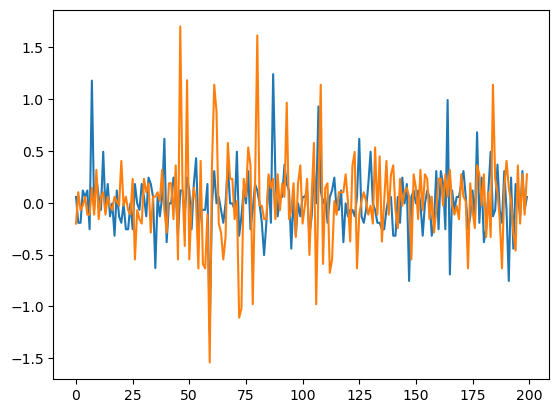

In [52]:
for i in range(2):
    plt.plot(windows[0][i])

In [18]:
repetitions = [1, 2, 3, 4, 5, 6]
stims = [1, 3]
train_windows = []
test_windows = []
for stimulus in stims:
    for repetition in repetitions:
        dbpth = DB5Path(df[(df.stimulus == stimulus) & (df.repetition == repetition)], stimulus, repetition)
        if repetition in train_set:
            train_windows += dbpth.get_windows(window_size=200, overlap=100)
        elif repetition in test_set:
            test_windows += dbpth.get_windows(window_size=200, overlap=100)

In [19]:
len(train_windows), len(test_windows)

(692, 336)

In [20]:
def splitxy(dfs : list, x_cols, y_col):
    x = []
    y = []
    for df in dfs:
        x.append(df[x_cols].to_numpy())
        y.append(df[y_col].to_numpy()[0]) # assume everything is of the same class
    return np.array(x), np.array(y).reshape(-1)

In [21]:
train_x, train_y = splitxy(train_windows, range(16), ['stimulus'])
test_x, test_y = splitxy(test_windows, range(16), ['stimulus'])

After performing a test-train split, we compute the log signatures on each window to a depth of 2. 

In [22]:
train_signatures = []
for window in tqdm(train_x):
    train_signatures.append(compute_log_signature(window, depth=2))
test_signatures = []
for window in tqdm(test_x):
    test_signatures.append(compute_log_signature(window, depth=2))
train_signatures = np.array(train_signatures)
test_signatures = np.array(test_signatures)

100%|██████████| 336/336 [00:00<00:00, 5074.34it/s]


In [23]:
train_signatures.shape, test_signatures.shape

((692, 136), (336, 136))

We use a SVM since it's not immediately apparent what to do with such high-dimensional data. The human action recognition example used a linear classifier with a dropout layer, which was trained.

In [24]:
from sklearn import svm

In [25]:
def accuracy(pred, true):
    assert len(pred) == len(true), "check lengths match"
    return np.sum((pred == true)) / len(pred)


In [26]:
assert accuracy(np.array([1, 1, 1, 2]), np.array([1, 2, 1, 2])) == 0.75

In [37]:
classifier = svm.SVC()

In [38]:
train_x.shape, train_y.shape

((692, 200, 16), (692, 1))

In [39]:
print(train_signatures.shape, train_y.shape)
print(test_signatures.shape, test_y.shape)

(692, 136) (692, 1)
(336, 136) (336, 1)


In [40]:
classifier.fit(train_signatures, train_y)

/home/alan/.miniconda3/envs/signatures/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [41]:
train_pred = classifier.predict(train_signatures)
print("training set accuracy:", accuracy(train_pred, train_y)

training set accuracy: 0.8526011560693642


In [42]:
pred = classifier.predict(test_signatures)

In [43]:
accuracy(pred, test_y)

0.6517857142857143

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [45]:
cm = confusion_matrix(test_y, pred)

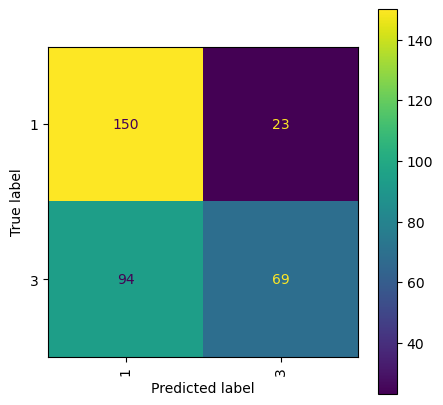

In [46]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(cm,
                                    display_labels=stims).plot(ax=ax,
                                                                       xticks_rotation="vertical")

## Try the same thing with glove data!

Let's stick to differentiating between stimuli $1$ and $3$ - pretty sure there should be some significant differences here. Let's look at glove data plots.

Let's look at just subject $1$, exercise $1$ vs exercise $3$'s activity so we can extract out what we think are relevant features.

In [53]:
#data_paths = [os.path.join(root, f"s1/S1_E{exercise}_A1.mat") for exercise in exercises]
data_paths = [os.path.join(root, f"s1/S1_E1_A1.mat")]
s1_df = load_subject(data_paths, col='glove')

<AxesSubplot: title={'center': 'Glove Electrode Signals, subject 1, exercise 1'}>

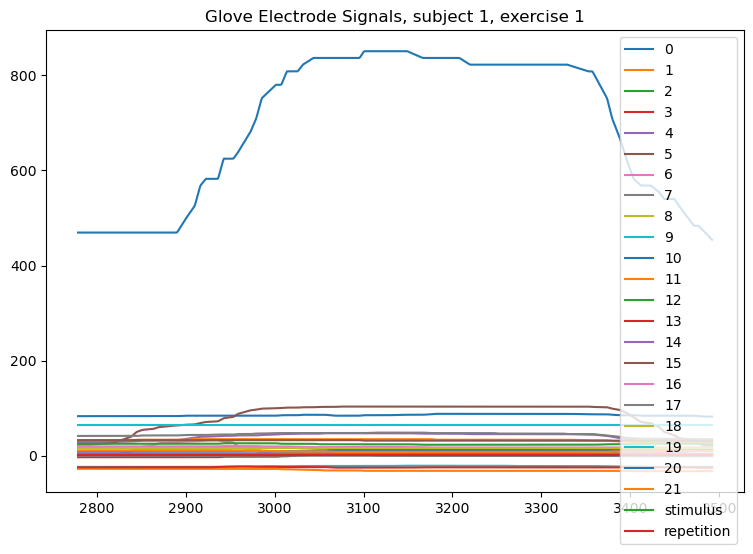

In [54]:
s1_df[(s1_df.stimulus==1) & (s1_df.repetition==2)].plot(figsize=(9,6), title="Glove Electrode Signals, subject 1, exercise 1")

<AxesSubplot: title={'center': 'Glove Electrode Signals, subject 1, exercise 3'}>

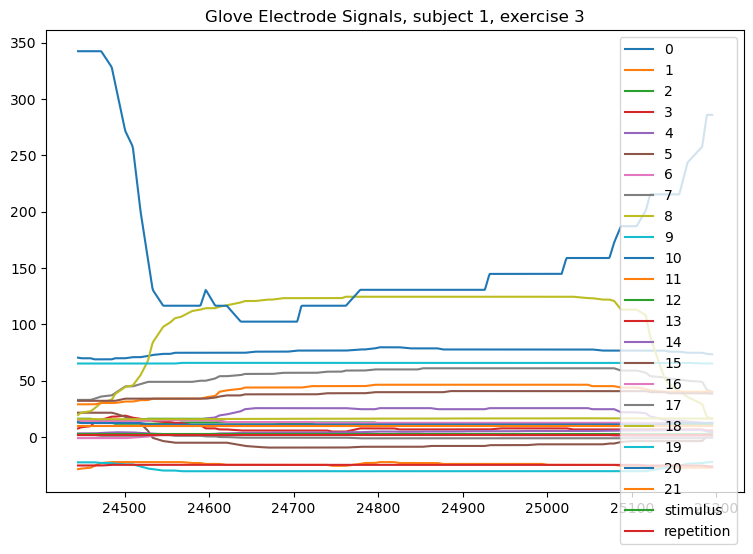

In [55]:
s1_df[(s1_df.stimulus==3) & (s1_df.repetition==2)].plot(figsize=(9,6), title="Glove Electrode Signals, subject 1, exercise 3")

*Using $1$ indexing...*

So, looks like sensors $11$ and $6$ are active in the first exercise (an index finger flexion) and sensors $11$ and $9$ are active in the second exercise (a middle finger flexion). Looking at the image, these make sense.

<img src="sensor_mapping.png" width=300>

In [56]:
subjects = range(1, 11)
exercises = [1]
root = './signatures_data/'
df = pd.DataFrame([])
for subject in subjects:
    data_paths = [os.path.join(root, f"s{subject}/S{subject}_E{exercise}_A1.mat") for exercise in exercises]
    cur_df = load_subject(data_paths, col='glove')
    df = pd.concat([df, cur_df], ignore_index=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,stimulus,repetition
0,81.193825,-25.613001,17.336512,-6.904053,12.986491,18.831488,1.902927,19.194145,6.613120,-22.310045,...,-3.972004,27.264063,21.547808,-0.084706,13.291741,65.754509,2.470584,24.564764,0,0
1,81.147217,-25.613001,17.336512,-6.949311,12.898676,18.659233,1.944808,19.242105,6.309145,-22.280998,...,-3.901077,27.264063,21.477554,-0.084706,13.291741,65.754509,2.470584,24.564764,0,0
2,81.100609,-25.613001,17.336512,-6.994570,12.810861,18.486980,1.986689,19.290066,6.005171,-22.251951,...,-3.830149,27.264063,21.407303,-0.084706,13.291741,65.754509,2.470584,24.564764,0,0
3,81.054001,-25.613001,17.336512,-7.039829,12.723045,18.314728,2.028570,19.338028,5.701196,-22.222904,...,-3.759222,27.264063,21.337051,-0.084706,13.291741,65.754509,2.470584,24.564764,0,0
4,81.007385,-25.613001,17.336512,-7.085087,12.635230,18.142475,2.070451,19.385988,5.397222,-22.193857,...,-3.688294,27.264063,21.266798,-0.084706,13.291741,65.754509,2.470584,24.564764,0,0


In [57]:
repetitions = [1, 2, 3, 4, 5, 6]
stims = [1, 3]
train_windows = []
test_windows = []
for stimulus in stims:
    for repetition in repetitions:
        dbpth = DB5Path(df[(df.stimulus == stimulus) & (df.repetition == repetition)], stimulus, repetition)
        if repetition in train_set:
            train_windows += dbpth.get_windows(window_size=200, overlap=100)
        elif repetition in test_set:
            test_windows += dbpth.get_windows(window_size=200, overlap=100)
train_x, train_y = splitxy(train_windows, [5,8,10], ['stimulus'])
test_x, test_y = splitxy(test_windows, [5,8,10], ['stimulus'])

In [59]:
train_x.shape, train_y.shape

((692, 200, 3), (692, 1))

In [60]:
train_signatures = []
for window in tqdm(train_x):
    train_signatures.append(compute_log_signature(window, depth=4))
test_signatures = []
for window in tqdm(test_x):
    test_signatures.append(compute_log_signature(window, depth=4))
train_signatures = np.array(train_signatures)
test_signatures = np.array(test_signatures)

100%|██████████| 336/336 [00:32<00:00, 10.46it/s]


In [62]:
train_signatures.shape, test_signatures.shape

((692, 32), (336, 32))

In [65]:
classifier = svm.SVC()
classifier.fit(train_signatures, train_y)
print("training set accuracy:", accuracy(classifier.predict(train_signatures), train_y))

training set accuracy: 0.8121387283236994


/home/alan/.miniconda3/envs/signatures/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [66]:
pred = classifier.predict(test_signatures)
print("testing set accuracy:", accuracy(pred, test_y))

testing set accuracy: 0.75


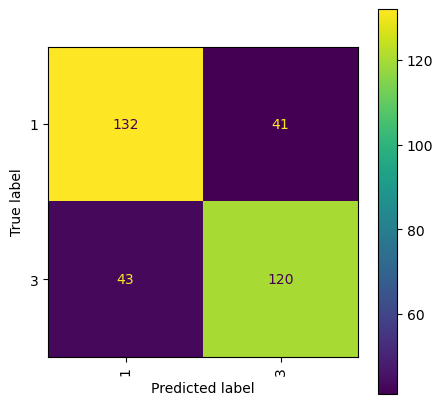

In [67]:
cm = confusion_matrix(test_y, pred)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(cm, display_labels=stims).plot(ax=ax,xticks_rotation="vertical")